<a href="https://colab.research.google.com/github/karlmel/Average-Distance-in-Buffer-Zone/blob/main/PredictEnergyConsumption_LightGbM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
import lightgbm as lgb
import warnings
import matplotlib.pyplot as plt

In [ ]:
df=pd.read_excel ("TUM_BEBTR_YAPIMSISTMLI_deneme.xlsx", index_col='BINAKODU')
df

,TOPLAM_INS,KOMPAKTLIK,EN_BOY,TABANALANI,bitisik,Brlsk_Oran,BITISIKENR,ZEMINUSTUK,TUM_KAT,YAPI_SISTE,YIL,Enerji_Ala,ENERJI
BINAKODU,,,,,,,,,,,,,
343045506,57687.904002,0.298379,0.442802,1407.0200,0.000000,0,0.00000,40,41,4,3,664.981286,2.162213e+07
296657430,397817.431795,0.139081,0.660311,33151.5000,0.000000,0,0.00000,4,12,4,4,82.141372,1.993036e+07
280886102,2954.304900,0.445071,0.955662,422.0440,0.000000,0,0.00000,6,7,4,4,343.906489,1.639040e+07
342225844,2128.086309,0.601486,0.433509,304.0120,0.000000,0,0.00000,4,7,4,3,108.465440,1.609417e+07
106089816,326281.421231,0.166879,0.376302,40785.2000,0.000000,0,0.00000,3,8,4,3,110.780497,1.602601e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...
264458050,121.227430,1.676175,0.633741,30.3069,0.000000,0,0.00000,3,4,3,4,377.602530,6.927325e+03
709440705,183.970895,1.393073,0.443870,45.9927,0.000000,0,0.00000,3,4,4,4,232.400847,6.910886e+03
274999481,137.418286,1.810000,0.318194,34.3546,0.000000,0,0.00000,2,4,4,4,271.835833,5.651212e+03


In [ ]:
#YAPI_SISTEM değişkenini dışarıda tutalım
df = df.drop(["Enerji_Ala","YIL", "YAPI_SISTE", "bitisik", "BITISIKENR", "Brlsk_Oran", "ZEMINUSTUK", "TUM_KAT"], axis = 1).astype("float64")
df

,TOPLAM_INS,KOMPAKTLIK,EN_BOY,TABANALANI,ENERJI
BINAKODU,,,,,
343045506,57687.904002,0.298379,0.442802,1407.0200,2.162213e+07
296657430,397817.431795,0.139081,0.660311,33151.5000,1.993036e+07
280886102,2954.304900,0.445071,0.955662,422.0440,1.639040e+07
342225844,2128.086309,0.601486,0.433509,304.0120,1.609417e+07
106089816,326281.421231,0.166879,0.376302,40785.2000,1.602601e+07
...,...,...,...,...,...
264458050,121.227430,1.676175,0.633741,30.3069,6.927325e+03
709440705,183.970895,1.393073,0.443870,45.9927,6.910886e+03
274999481,137.418286,1.810000,0.318194,34.3546,5.651212e+03


In [ ]:
#outlierları hesaplamak için pyod import edilmeli
!pip install pyod

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.0/165.0 kB 3.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyod: filename=pyod-2.0.0-py3-none-any.whl size=196324 sha256=fc7bd5ef0ecd4df6755f568684d5c6c4f467a6d0c83845cdbb7acb4cda9d5519
  Stored in directory: /root/.cache/pip/wheels/15/0e/91/96b270e6741d4eece88727489411330226ff47ac1cb9ea0097
Successfully built pyod


In [ ]:
# Outlierları tespit edelim

from pyod.models.ecod import ECOD

clf = ECOD()
clf.fit(df)
outliers = clf.predict(df)

df["outliers"] = outliers

# Outliersız data
df_no_outliers = df[df["outliers"] == 0]
df_no_outliers = df_no_outliers.drop(["outliers"], axis = 1)

# Outlierlı data
df_with_outliers = df.copy()
df_with_outliers = df_with_outliers.drop(["outliers"], axis = 1)

print(df_no_outliers.shape)
print(df_with_outliers.shape)

(36901, 5)
(41001, 5)


In [ ]:
df=df_no_outliers

In [ ]:
X = df.drop('ENERJI',axis=1).values
y = df['ENERJI'].values

In [ ]:
y=np.log(y)

In [ ]:
# NumPy dizisini Pandas Series'e dönüştürme
y_series = pd.Series(y)

# y_series'in describe() fonksiyonunu kullanarak istatistiksel özetini alın
y_series.describe()

count    36901.000000
mean        11.589815
std          0.804649
min          9.320681
25%         11.011429
50%         11.581114
75%         12.186195
max         15.992202
dtype: float64

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.30,random_state=42)

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()

# Veriyi standardize edelim
scaler.fit_transform(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

In [ ]:
# Uyarıları kapatın
warnings.filterwarnings('ignore')

In [ ]:
# LightGBM modelini ve Random Search parametre aralıklarını tanımlayın
lgbm = lgb.LGBMRegressor(random_state=42)

param_dist = {
    'num_leaves': [31, 50, 100, 200],
    'max_depth': [-1, 10, 20, 30, 40, 50],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [100, 500, 1000],
    'subsample': [0.6, 0.7, 0.8, 0.9, 1.0],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9, 1.0],
    'reg_alpha': [0.0, 0.1, 0.5, 1.0],
    'reg_lambda': [0.0, 0.1, 0.5, 1.0]
}

random_search = RandomizedSearchCV(estimator=lgbm, param_distributions=param_dist,
                                   n_iter=100, cv=3, verbose=2, random_state=42, n_jobs=-1, scoring='neg_mean_squared_error')

In [ ]:
# Random Search uygulayın ve en iyi parametreleri bulun
random_search.fit(X_train, y_train)

print(f"En iyi parametreler: {random_search.best_params_}")


Fitting 3 folds for each of 100 candidates, totalling 300 fits
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001919 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1020
[LightGBM] [Info] Number of data points in the train set: 25830, number of used features: 4
[LightGBM] [Info] Start training from score 11.587492
En iyi parametreler: {'subsample': 0.7, 'reg_lambda': 1.0, 'reg_alpha': 0.5, 'num_leaves': 100, 'n_estimators': 1000, 'max_depth': -1, 'learning_rate': 0.01, 'colsample_bytree': 1.0}


In [ ]:
# En iyi modeli kullanarak test setinde tahmin yapın
best_model = random_search.best_estimator_

# Test seti üzerinde tahmin yapın
y_test_pred = best_model.predict(X_test)

# Performansı değerlendirin
test_mse = mean_squared_error(y_test, y_test_pred)
test_rmse = np.sqrt(test_mse)
test_r2 = r2_score(y_test, y_test_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)


print(f"Test Seti MSE: {test_mse}")
print(f"Test Seti RMSE: {test_rmse}")
print(f"Test Seti R^2: {test_r2}")
print(f"Test Seti MAE: {test_mae}")

Test Seti MSE: 0.15383651006347576
Test Seti RMSE: 0.3922199766246943
Test Seti R^2: 0.7647480586825209
Test Seti MAE: 0.2780564573750124


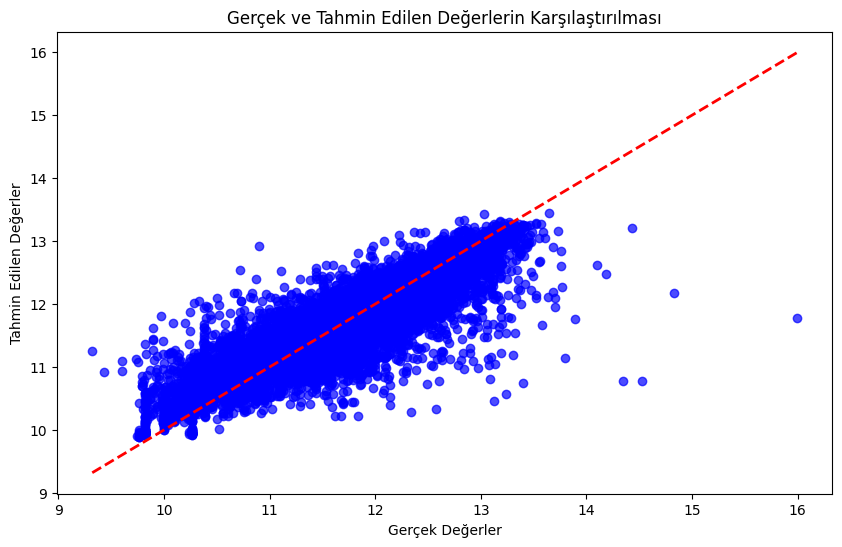

In [ ]:
# Tahmin ve gerçek değerleri görselleştirin
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('Gerçek Değerler')
plt.ylabel('Tahmin Edilen Değerler')
plt.title('Gerçek ve Tahmin Edilen Değerlerin Karşılaştırılması')

plt.savefig('LightGbM_Turkce.png', format='png')

plt.show()

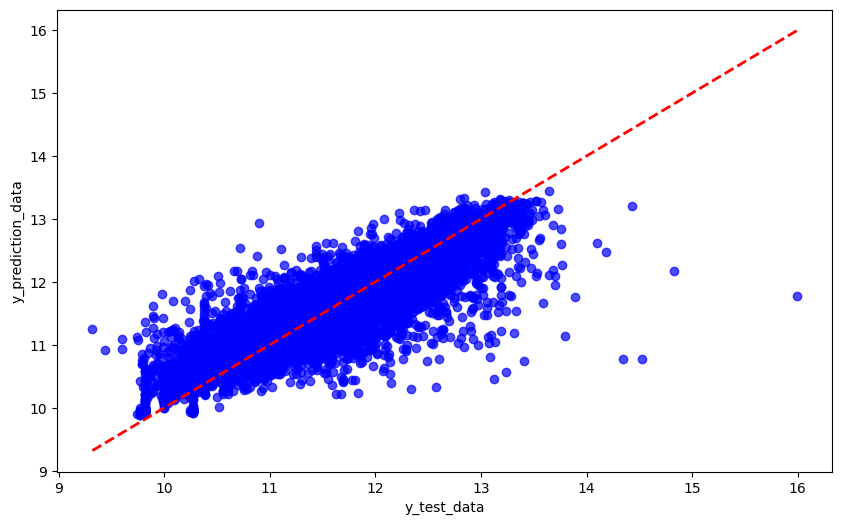

In [ ]:
# Tahmin ve gerçek değerleri görselleştirin
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_test_pred, alpha=0.7, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.xlabel('y_test_data')
plt.ylabel('y_prediction_data')

plt.savefig('LightGbM.png', format='png')

plt.show()